# Regresión lineal con gradiente descendiente

<img src="img/LR_neuron_1.png" width="600">

<img src="img/Online_Batch_GD_2.png" width="700">

<img src="img/MiniBatch_GD_3.png" width="700">

<img src="img/LR_Loss_derivate_4.png" width="700">

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import torch

from torch.autograd import grad
import torch.nn.functional as F

%matplotlib inline

## Cargando y preparando el dataset 

In [2]:
df = pd.read_csv('./datasets/linreg-data.csv', index_col=0)
df.tail()

,x1,x2,y
995,-0.942094,-0.835856,-22.324428
996,1.222445,-0.403177,-52.121493
997,-0.112466,-1.688230,-57.043196
998,-0.403459,-0.412272,-27.701833
999,0.021351,-0.499017,-9.804714


In [3]:
# Assign features and target

X = torch.tensor(df[['x1', 'x2']].values, dtype=torch.float)
y = torch.tensor(df['y'].values, dtype=torch.float)

# Shuffling & train/test split

torch.manual_seed(123)
shuffle_idx = torch.randperm(y.size(0), dtype=torch.long)

X, y = X[shuffle_idx], y[shuffle_idx]

percent70 = int(shuffle_idx.size(0)*0.7)

X_train, X_test = X[shuffle_idx[:percent70]], X[shuffle_idx[percent70:]]
y_train, y_test = y[shuffle_idx[:percent70]], y[shuffle_idx[percent70:]]

# Normalize (mean zero, unit variance)

mu, sigma = X_train.mean(dim=0), X_train.std(dim=0)
X_train = (X_train - mu) / sigma
X_test = (X_test - mu) / sigma

<br>
<br>

## Implementando el Modelo de regresión lineal de forma manual

In [4]:
class LinearRegression1():
    def __init__(self, num_features):
        self.num_features = num_features
        self.weight = torch.zeros(num_features, 1, 
                                  dtype=torch.float)
        self.bias = torch.zeros(1, dtype=torch.float)

    def forward(self, x):
        netinputs = x @ self.weight + self.bias
        activations = netinputs
        return activations.view(-1)
        
    def backward(self, x, yhat, y):  
        
        grad_loss_yhat = 2*(y - yhat)
        
        grad_yhat_weights = -x
        grad_yhat_bias = -1.
        
        # Regla de la cadena
        grad_loss_weights =  ( grad_yhat_weights.t() @ grad_loss_yhat.view(-1, 1) )/ y.size(0)

        grad_loss_bias = torch.sum(grad_yhat_bias*grad_loss_yhat) / y.size(0)
        
        # returna el negativo del gradiente
        return (-1)*grad_loss_weights, (-1)*grad_loss_bias

### Entrenamiento y evaluación

In [7]:
####################################################
##### Entrenamiento y validación
###################################################

def loss_func(yhat, y):
    return torch.mean((yhat - y)**2)


def train(model, x, y, num_epochs,
          learning_rate=0.01, seed=123, minibatch_size=10):
    cost = []
    
    torch.manual_seed(seed)
    for e in range(num_epochs):
        
        #### Shuffle los epochs
        shuffle_idx = torch.randperm(y.size(0), dtype=torch.long)
        minibatches = torch.split(shuffle_idx, minibatch_size)
        
        for minibatch_idx in minibatches:
#Linear
            #### Calcula salidas ####
            yhat = model.forward(x[minibatch_idx])

            #### Calcula gradientes ####
            negative_grad_w, negative_grad_b = \
                model.backward(x[minibatch_idx], yhat, y[minibatch_idx])

            #### Actualiza los pesos ####
            model.weight += learning_rate * negative_grad_w
            model.bias += learning_rate * negative_grad_b
            
            ####  Registro en el minibatch ####
            #minibatch_loss = loss(yhat, y[minibatch_idx])
            #print('    Minibatch MSE: %.3f' % minibatch_loss)

        #### Registro ####
        yhat = model.forward(x)
        curr_loss = loss_func(yhat, y)
        print('Epoch: %03d' % (e+1), end="")
        print(' | MSE: %.5f' % curr_loss)
        cost.append(curr_loss)

    return cost

### Entrenando el modelo de regresión lineal

In [8]:
model = LinearRegression1(num_features=X_train.size(1))
cost = train(model, 
             X_train, y_train, 
             num_epochs=50, 
             learning_rate=0.01,
             minibatch_size=10)

Epoch: 001 | MSE: 459.60974
Epoch: 002 | MSE: 378.76865
Epoch: 003 | MSE: 372.19711
Epoch: 004 | MSE: 371.73517
Epoch: 005 | MSE: 371.71585
Epoch: 006 | MSE: 371.69363
Epoch: 007 | MSE: 371.70804
Epoch: 008 | MSE: 371.66751
Epoch: 009 | MSE: 371.90137
Epoch: 010 | MSE: 372.33533
Epoch: 011 | MSE: 371.77298
Epoch: 012 | MSE: 371.63214
Epoch: 013 | MSE: 371.71933
Epoch: 014 | MSE: 371.68173
Epoch: 015 | MSE: 371.89890
Epoch: 016 | MSE: 372.00119
Epoch: 017 | MSE: 371.88901
Epoch: 018 | MSE: 371.66327
Epoch: 019 | MSE: 371.77960
Epoch: 020 | MSE: 371.64783
Epoch: 021 | MSE: 371.69937
Epoch: 022 | MSE: 371.78836
Epoch: 023 | MSE: 371.72784
Epoch: 024 | MSE: 371.74640
Epoch: 025 | MSE: 372.03195
Epoch: 026 | MSE: 371.87531
Epoch: 027 | MSE: 371.74689
Epoch: 028 | MSE: 371.85193
Epoch: 029 | MSE: 371.77881
Epoch: 030 | MSE: 371.66104
Epoch: 031 | MSE: 371.68863
Epoch: 032 | MSE: 371.76370
Epoch: 033 | MSE: 371.68677
Epoch: 034 | MSE: 371.72476
Epoch: 035 | MSE: 371.77695
Epoch: 036 | MSE: 37

## Evaluate Linear Regression Model

### Plot MSE

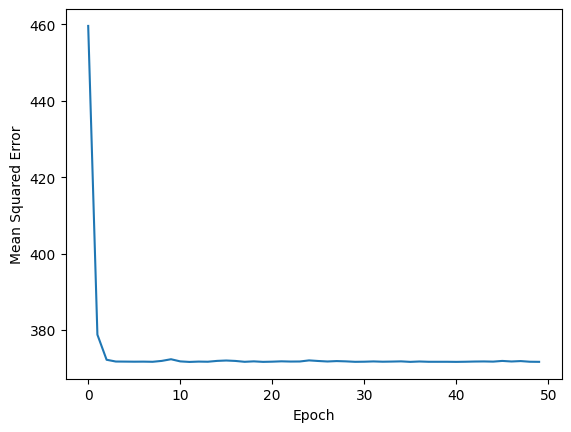

In [9]:
plt.plot(range(len(cost)), cost)
plt.ylabel('Mean Squared Error')
plt.xlabel('Epoch')
plt.show()

In [10]:
train_pred = model.forward(X_train)
test_pred = model.forward(X_test)

print('Train MSE: %.5f' % loss_func(train_pred, y_train))
print('Test MSE: %.5f' % loss_func(test_pred, y_test))

Train MSE: 371.65445
Test MSE: 406.64313


### Comparando con la solución analítica

In [11]:
print('Weights', model.weight)
print('Bias', model.bias)

Weights tensor([[ 0.2111],
        [37.7388]])
Bias tensor([-0.5895])


In [12]:
def analytical_solution(x, y):
    Xb = torch.cat( (torch.ones((x.size(0), 1)), x), dim=1)
    w = torch.zeros(x.size(1))
    z = torch.inverse(torch.matmul(Xb.t(), Xb))
    params = torch.matmul(z, torch.matmul(Xb.t(), y))
    b, w = torch.tensor([params[0]]), params[1:].view(x.size(1), 1)
    return w, b

w, b = analytical_solution(X_train, y_train)
print('Analytical weights', w)
print('Analytical bias', b)

Analytical weights tensor([[ 0.3624],
        [37.8801]])
Analytical bias tensor([-0.5464])


# Modelo Semimanual (con autograd)

In [13]:
class LinearRegression2():
    def __init__(self, num_features):
        self.num_features = num_features
        self.weight = torch.zeros(num_features, 1, 
                                  dtype=torch.float,
                                  requires_grad=True)
        self.bias = torch.zeros(1, dtype=torch.float,
                                requires_grad=True)

    def forward(self, x):
        netinputs = x @ self.weight + self.bias
        activations = netinputs
        return activations.view(-1)

    
####################################################
##### Entrenamiento y validación
###################################################

def loss_func(yhat, y):
    return torch.mean((yhat - y)**2)


def train(model, x, y, num_epochs,
          learning_rate=0.01, seed=123, minibatch_size=10):
    cost = []
    
    torch.manual_seed(seed)
    for e in range(num_epochs):
        
        #### Shuffle los epochs
        shuffle_idx = torch.randperm(y.size(0), dtype=torch.long)
        minibatches = torch.split(shuffle_idx, minibatch_size)
        
        for minibatch_idx in minibatches:

            #### Calcula salidas ####
            yhat = model.forward(x[minibatch_idx])
            loss = loss_func(yhat, y[minibatch_idx])
            
            #### Calcula gradientes ####
            
            negative_grad_w = grad(loss, model.weight, retain_graph=True)[0] * (-1)
            negative_grad_b = grad(loss, model.bias)[0] * (-1)
            
            
            #### Actualiza pesos ####

            model.weight = model.weight + learning_rate * negative_grad_w
            model.bias = model.bias + learning_rate * negative_grad_b

        #### Registro ####
        with torch.no_grad():
            # evita el grafo durante la evaluación y guarda memoria
            yhat = model.forward(x)
            curr_loss = loss_func(yhat, y)
            print('Epoch: %03d' % (e+1), end="")
            print(' | MSE: %.5f' % curr_loss)
            cost.append(curr_loss)

    return cost

In [14]:
model = LinearRegression2(num_features=X_train.size(1))
cost = train(model, 
             X_train, y_train.float(),
             num_epochs=20,
             learning_rate=0.01,
             seed=123,
             minibatch_size=10)

Epoch: 001 | MSE: 459.60974
Epoch: 002 | MSE: 378.76865
Epoch: 003 | MSE: 372.19711
Epoch: 004 | MSE: 371.73517
Epoch: 005 | MSE: 371.71585
Epoch: 006 | MSE: 371.69363
Epoch: 007 | MSE: 371.70804
Epoch: 008 | MSE: 371.66751
Epoch: 009 | MSE: 371.90137
Epoch: 010 | MSE: 372.33536
Epoch: 011 | MSE: 371.77295
Epoch: 012 | MSE: 371.63214
Epoch: 013 | MSE: 371.71933
Epoch: 014 | MSE: 371.68173
Epoch: 015 | MSE: 371.89890
Epoch: 016 | MSE: 372.00119
Epoch: 017 | MSE: 371.88901
Epoch: 018 | MSE: 371.66327
Epoch: 019 | MSE: 371.77960
Epoch: 020 | MSE: 371.64783


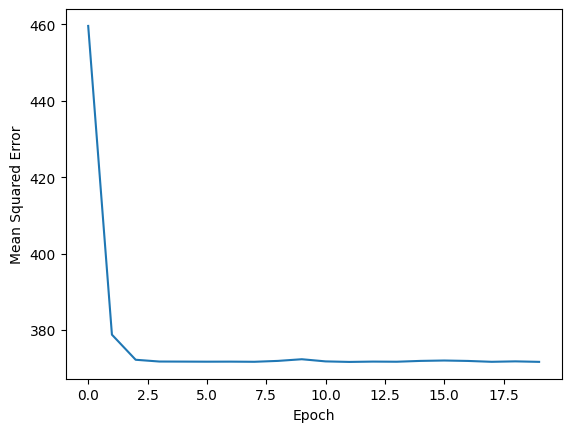

In [15]:
plt.plot(range(len(cost)), cost)
plt.ylabel('Mean Squared Error')
plt.xlabel('Epoch')
plt.show()

# Modelo Automático

In [16]:
class LinearRegression3(torch.nn.Module):
    def __init__(self, num_features):
        super(LinearRegression3, self).__init__()
        self.linear = torch.nn.Linear(num_features, 1)
        
        # cambio los pesos de aleatorios (que es por defecto) a cero
        # (nunca hacer esto con redes en general)
        self.linear.weight.detach().zero_()
        self.linear.bias.detach().zero_()

    def forward(self, x):
        netinputs = self.linear(x)
        activations = netinputs
        return activations.view(-1)

    
####################################################
##### Entrenamiento y validación
###################################################


def train(model, x, y, num_epochs,
          learning_rate=0.01, seed=123, minibatch_size=10):
    cost = []
    
    torch.manual_seed(seed)
    
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    
    for e in range(num_epochs):
        
        #### Shuffle para minibatches
        shuffle_idx = torch.randperm(y.size(0), dtype=torch.long)
        minibatches = torch.split(shuffle_idx, minibatch_size)
        
        for minibatch_idx in minibatches:

            #### Calcula salidas ####
            yhat = model.forward(x[minibatch_idx])
            
            # Tambien se podria usar una funcion de costo propia
            loss = F.mse_loss(yhat, y[minibatch_idx])
            
            #### Reinica los gradientes de la iteracion previa ####
            optimizer.zero_grad()
            
            #### Calcula gradientes ####
            loss.backward()
            
            #### Actualiza pesos ####
            optimizer.step()

        #### Registro ####
        with torch.no_grad():
            # Para guardar memoria durante la evaluacion
            yhat = model.forward(x)
            curr_loss = loss_func(yhat, y)
            print('Epoch: %03d' % (e+1), end="")
            print(' | MSE: %.5f' % curr_loss)
            cost.append(curr_loss)

    return cost

In [17]:
model = LinearRegression3(num_features=X_train.size(1))
cost = train(model, 
             X_train, y_train.float(),
             num_epochs=20,
             learning_rate=0.01,
             seed=123,
             minibatch_size=10)

Epoch: 001 | MSE: 459.60974
Epoch: 002 | MSE: 378.76865
Epoch: 003 | MSE: 372.19711
Epoch: 004 | MSE: 371.73517
Epoch: 005 | MSE: 371.71585
Epoch: 006 | MSE: 371.69363
Epoch: 007 | MSE: 371.70804
Epoch: 008 | MSE: 371.66751
Epoch: 009 | MSE: 371.90137
Epoch: 010 | MSE: 372.33536
Epoch: 011 | MSE: 371.77295
Epoch: 012 | MSE: 371.63214
Epoch: 013 | MSE: 371.71933
Epoch: 014 | MSE: 371.68173
Epoch: 015 | MSE: 371.89890
Epoch: 016 | MSE: 372.00119
Epoch: 017 | MSE: 371.88901
Epoch: 018 | MSE: 371.66327
Epoch: 019 | MSE: 371.77960
Epoch: 020 | MSE: 371.64783


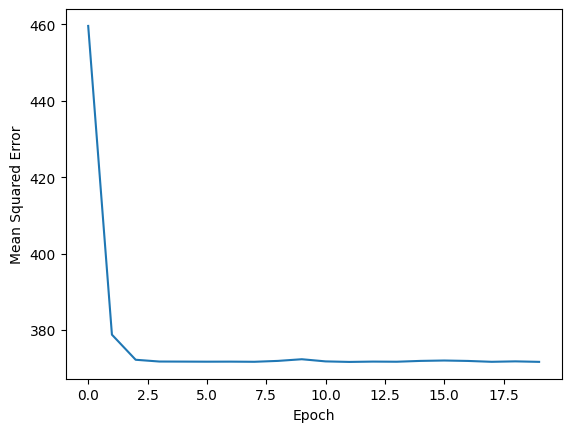

In [19]:
plt.plot(range(len(cost)), cost)
plt.ylabel('Mean Squared Error')
plt.xlabel('Epoch')
plt.show()